In [2]:
# Name: Danyang Zhangn
# Email: daz040@eng.ucsd.edu
# PID: A53104006
PYBOLT = False
# need to remove %, ! in .py file in order to run on PYBOLT
if PYBOLT:
    from pyspark import SparkContext
    sc = SparkContext()


from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils



### Higgs data set
* **URL:** http://archive.ics.uci.edu/ml/datasets/HIGGS#  
* **Abstract:** This is a classification problem to distinguish between a signal process which produces Higgs bosons and a background process which does not.

**Data Set Information:**  
The data has been produced using Monte Carlo simulations. The first 21 features (columns 2-22) are kinematic properties measured by the particle detectors in the accelerator. The last seven features are functions of the first 21 features; these are high-level features derived by physicists to help discriminate between the two classes. There is an interest in using deep learning methods to obviate the need for physicists to manually develop such features. Benchmark results using Bayesian Decision Trees from a standard physics package and 5-layer neural networks are presented in the original paper. The last 500,000 examples are used as a test set.



In [3]:
#define feature names
feature_text = ('lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, '
                'jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, '
                'jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb')
features=[a.strip() for a in feature_text.split(',')]
if not PYBOLT:
    print len(features), features

28 ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [4]:
# create a directory called higgs, download and decompress HIGGS.csv.gz into it
if not PYBOLT:
    from os.path import exists
    if not exists('higgs'):
        print "creating directory higgs"
        !mkdir higgs
    %cd higgs
    if not exists('HIGGS.csv'):
        if not exists('HIGGS.csv.gz'):
            print 'downloading HIGGS.csv.gz'
            !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
        print 'decompressing HIGGS.csv.gz --- May take 5-10 minutes'
        !gunzip -f HIGGS.csv.gz
    !ls -l
    %cd ..

/vagrant/UCSD_BigData_2016/Solutions/HW-5/higgs
total 6891560
-rw------- 1 501 dialout 4240547840 May 16 01:46 HIGGS.csv
-rw-rw-r-- 1 501 dialout 2816407858 May 16 01:44 HIGGS.csv.gz
/vagrant/UCSD_BigData_2016/Solutions/HW-5


### As done in previous notebook, create RDDs from raw data and build Gradient boosting and Random forests models. Consider doing 1% sampling since the dataset is too big for your local machine

In [5]:
if not PYBOLT:
    !head -2 higgs/HIGGS.csv

1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
1.000000000000000000e+00,9.075421094894409180e-01,3.291472792625427246e-01,3.594118654727935791e-01,1.497969865798950195e+00,-3.130095303058624268e-01,1.095530629158020020e+00,-5.575249195098876953e-01,-1.588229775428771973e+00,2.173076152801513672e+00,8.12581181526

In [6]:
if PYBOLT:
    path = '/HIGGS/HIGGS.csv'
else:
    path = 'higgs/HIGGS.csv'
    
inputRDD = sc.textFile(path)
# inputRDD.first()

In [7]:
Data = inputRDD.map(lambda line: [float(x.strip()) for x in line.split(',')])\
     .map(lambda p: LabeledPoint(p[0], p[1:]))
# Data.first()

### Reducing data size
In order to see the effects of overfitting more clearly, we reduce the size of the data by a factor of 100

In [12]:
if not PYBOLT:
    percent = 1
else:
    percent = 10

In [29]:
if not PYBOLT:
    Data1 = Data.sample(False, percent/100.0 seed=255).cache()
else:
    Data1 = Data.sample(False, percent/100.0, s, seed=255).cache()

(trainingData, testData)=Data1.randomSplit([0.7, 0.3], seed=255)
if not PYBOLT:
    print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(), trainingData.cache().count(), testData.cache().count())

Sizes: Data1=58249, trainingData=40843, testData=17406


In [30]:
counts = testData.map(lambda lp: (lp.label, 1)).reduceByKey(lambda x,y: x+y).collect()
counts.sort(key=lambda x: x[1], reverse=True)
counts

[(1.0, 9206), (0.0, 8200)]

### Gradient Boosted Trees

In [ ]:
from time import time
errors = {}
if not PYBOLT:
    depths = [1, 3, 6, 10]
else:
    depths = [15]
    
for depth in depths:
    start = time()
    model = GradientBoostedTrees.trainClassifier(trainingData, {}, maxDepth=depth, learningRate=0.3, numIterations=10)
    # numIterations is the numTrees
    #print model.toDebugString()
    
    errors[depth] = {}
    dataSets = {'train': trainingData, 'test': testData}
    for name in dataSets.keys():  # Calculate errors on TRAIN and TEST sets
        data = dataSets[name]
        Predicted = model.predict(data.map(lambda x: x.features))  
        LabelsAndPredictions = data.map(lambda x: x.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v, p): v != p).count()/float(data.count())  # zip
        errors[depth][name] = Err
    if not PYBOLT:
        print depth, errors[depth], int(time()-start), 'seconds'
    else:
        print depth, errors[depth]

if not PYBOLT:
    print errors

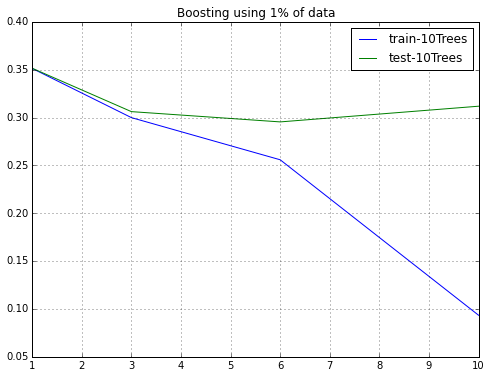

In [27]:
if not PYBOLT:
    B10 = errors
    # Plot Train/test accuracy vs Depth of trees graph
    %matplotlib inline
    from plot_utils import *
    make_figure([B10], ['10Trees'], Title='Boosting using %d%% of data' % percent) 

### Random Forests

In [14]:
if not PYBOLT:
    from time import time
    from pyspark.mllib.tree import RandomForest
    errors={}
    for depth in [1, 3, 6, 10, 15, 20]:
        start=time()
        model = RandomForest.trainClassifier(trainingData, 2, {}, maxDepth=depth, numTrees=10)
        #print model.toDebugString()
        errors[depth]={}
        dataSets={'train':trainingData,'test':testData}
        for name in dataSets.keys():  # Calculate errors on train and test sets
            data = dataSets[name]
            Predicted = model.predict(data.map(lambda x: x.features))  
            LabelsAndPredictions = data.map(lambda x: x.label).zip(Predicted)
            Err = LabelsAndPredictions.filter(lambda (v, p): v != p).count()/float(data.count())  # zip
            errors[depth][name] = Err

        print depth,errors[depth],int(time()-start),'seconds'
    print errors

1 {'test': 0.4127396627396627, 'train': 0.41523365632282594} 24 seconds
3 {'test': 0.35683760683760685, 'train': 0.35420090764135903} 26 seconds
6 {'test': 0.3223030723030723, 'train': 0.3167668342941249} 37 seconds
10 {'test': 0.30474705474705477, 'train': 0.25460566662578193} 67 seconds
15 {'test': 0.31352506352506354, 'train': 0.09898196982705752} 171 seconds
20 {'test': 0.3225340725340725, 'train': 0.0245799092358641} 312 seconds
{1: {'test': 0.4127396627396627, 'train': 0.41523365632282594}, 3: {'test': 0.35683760683760685, 'train': 0.35420090764135903}, 6: {'test': 0.3223030723030723, 'train': 0.3167668342941249}, 10: {'test': 0.30474705474705477, 'train': 0.25460566662578193}, 15: {'test': 0.31352506352506354, 'train': 0.09898196982705752}, 20: {'test': 0.3225340725340725, 'train': 0.0245799092358641}}


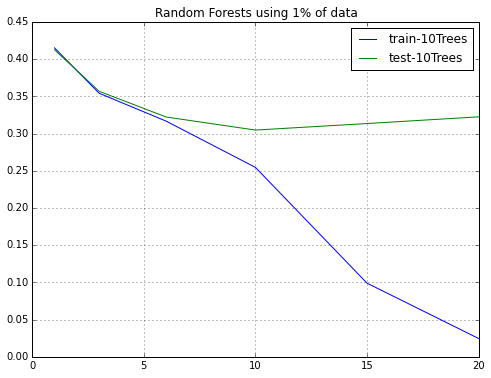

In [15]:
if not PYBOLT:
    RF_10trees = errors
    # Plot Train/test accuracy vs Depth of trees graph
    make_figure([RF_10trees], ['10Trees'], Title='Random Forests using %d%% of data' % percent)

### Now plot B10 and RF_10trees performance curves in the same graph

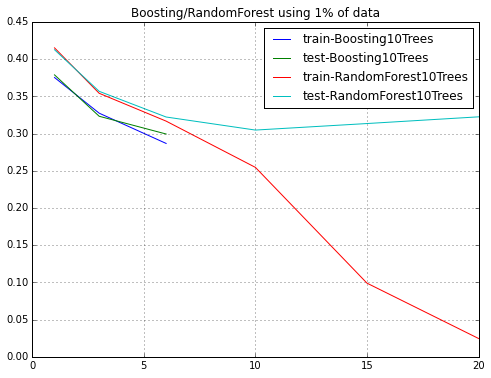

In [23]:
if not PYBOLT:
    make_figure([B10, RF_10trees], ['Boosting10Trees', 'RandomForest10Trees'], 
                Title='Boosting/RandomForest using %d%% of data' % percent)